### Run these first!

In [1]:
install.packages("tidymodels")
install.packages("kknn")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘Rcpp’, ‘diagram’, ‘lava’, ‘listenv’, ‘parallelly’, ‘prodlim’, ‘future’, ‘warp’, ‘iterators’, ‘lhs’, ‘DiceDesign’, ‘patchwork’, ‘globals’, ‘clock’, ‘gower’, ‘ipred’, ‘timeDate’, ‘furrr’, ‘slider’, ‘foreach’, ‘GPfit’, ‘modelenv’, ‘conflicted’, ‘dials’, ‘hardhat’, ‘infer’, ‘modeldata’, ‘parsnip’, ‘recipes’, ‘rsample’, ‘tune’, ‘workflows’, ‘workflowsets’, ‘yardstick’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘igraph’




In [29]:
library(tidyverse)
library(repr)
library(tidymodels)
library(kknn)
set.seed(727)

In [28]:
set.seed(727)
#reads the raw data sets and converts them into tibbles with no column names
cleveland_data <- read_delim('https://raw.githubusercontent.com/xonew/DSCI-100-002-Group-26/main/Data/processed.cleveland.data', col_names = FALSE) |> as_tibble()
hungarian_data <- read_delim('https://raw.githubusercontent.com/xonew/DSCI-100-002-Group-26/main/Data/processed.hungarian.data', col_names = FALSE) |> as_tibble()
swiss_data <- read_delim('https://raw.githubusercontent.com/xonew/DSCI-100-002-Group-26/main/Data/processed.switzerland.data', col_names = FALSE) |> as_tibble()
va_data <- read_delim('https://raw.githubusercontent.com/xonew/DSCI-100-002-Group-26/main/Data/processed.switzerland.data', col_names = FALSE) |> as_tibble()

#combines the two data sets into one
heart_data <- rbind(cleveland_data, hungarian_data, swiss_data, va_data)

#assigns names to the columns based on information from the website
colnames(heart_data) <- c('age', 'sex', 'chest_pain', 'trestbps', 'chol', 'fbs', 'restecg', 'max_hr',
              'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num')

#converts all categorical attributes into factors
heart_data <- mutate(heart_data, sex = as.factor(sex), chest_pain = as.factor(chest_pain),
    num = replace(num, num > 0, 1), num = as.factor(num), fbs = as.factor(fbs), restecg = as.factor(restecg),
    exang = as.factor(exang), thal = as.factor(thal), slope = as.factor(slope), ca = as.factor(ca)) |>

#removes missing values from the cholesterol and resting blood pressure columns
filter(chol != '?', trestbps != '?') |>

#converts all necessary numerical attributes into doubles
mutate(chol = as.double(chol), trestbps = as.double(trestbps), max_hr = as.double(max_hr))

#splits data into testing and training sets
heart_split <- heart_data |>
  initial_split( prop = 0.75, strata = num)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)
heart_train

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X5, X6, X7, X8, X9, X11, X12, X13
dbl (5): X1, X2, X3, X10, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 123 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X6, X7, X8, X9, X10, X11, X12, X13
dbl (5): X1, X2, X3, X5, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or 

age,sex,chest_pain,trestbps,chol,fbs,restecg,max_hr,exang,oldpeak,slope,ca,thal,num
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<chr>,<fct>,<fct>,<fct>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
57,0,4,120,354,0,0,163,1,0.6,1,0.0,3.0,0
57,1,4,140,192,0,0,148,0,0.4,2,0.0,6.0,0
44,1,2,120,263,0,0,173,0,0,1,0.0,7.0,0
52,1,3,172,199,1,0,162,0,0.5,1,0.0,7.0,0
57,1,3,150,168,0,0,174,0,1.6,1,0.0,3.0,0
54,1,4,140,239,0,0,160,0,1.2,1,0.0,3.0,0
48,0,3,130,275,0,0,139,0,0.2,1,0.0,3.0,0


[1] 9

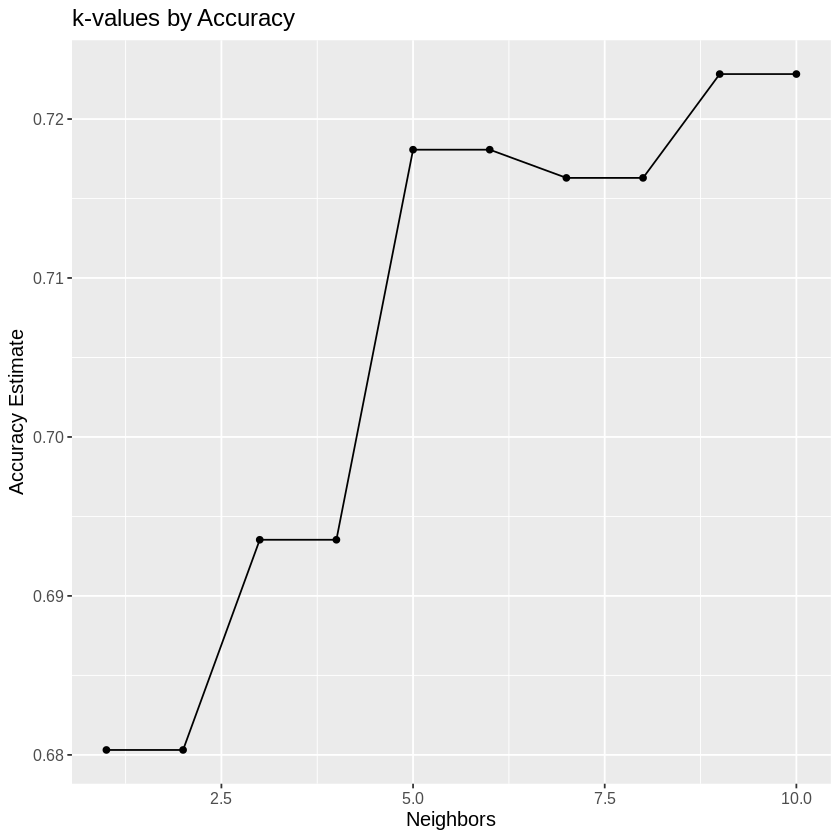

In [30]:
set.seed(727)
# creating the recipe for everything
heart_recipe <- recipe(num ~ age + trestbps + chol + max_hr , data = heart_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

ks <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

data_vfold <- vfold_cv(heart_train, v = 10, strata = num)

# creating the spec for the vfold
knn_spec_v <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")


#creating the workflow for the vfold

accuracies <- workflow() |>
  add_recipe(heart_recipe) |>
  add_model(knn_spec_v) |>
  tune_grid(resamples = data_vfold, grid = ks) |>
  collect_metrics() |>
  filter(.metric == "accuracy")

#plot of accuracy by k value
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate", title = "k-values by Accuracy") +
  theme(text = element_text(size = 12))

accuracy_vs_k

k_min <- accuracies |>
    arrange(desc(mean)) |>
    slice(1)|>
    pull(neighbors)

# printing the number of ks we use
k_min



In [48]:
set.seed(727)
# creating the spec for the final model
knn_spec_f <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) |>
  set_engine("kknn") |>
  set_mode("classification")

#creating the workflow for the final model
knn_fit <- workflow() |>
  add_recipe(heart_recipe) |>
  add_model(knn_spec_f) |>
  fit(data = heart_train)

#determining the accuracy using our testing set
predictions <- knn_fit |>
           predict(heart_test) |>
          bind_cols(heart_test |> select(num, age, trestbps, chol, max_hr))

#metrics
metrics <- predictions |>
           metrics(truth = num, estimate = .pred_class)
metrics





.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7609756
kap,binary,0.5101195


In [47]:
#confidence matrix
conf_mat <- predictions |>
    conf_mat(truth = num, estimate = .pred_class)

conf_mat

          Truth
Prediction  0  1
         0 62 23
         1 26 94

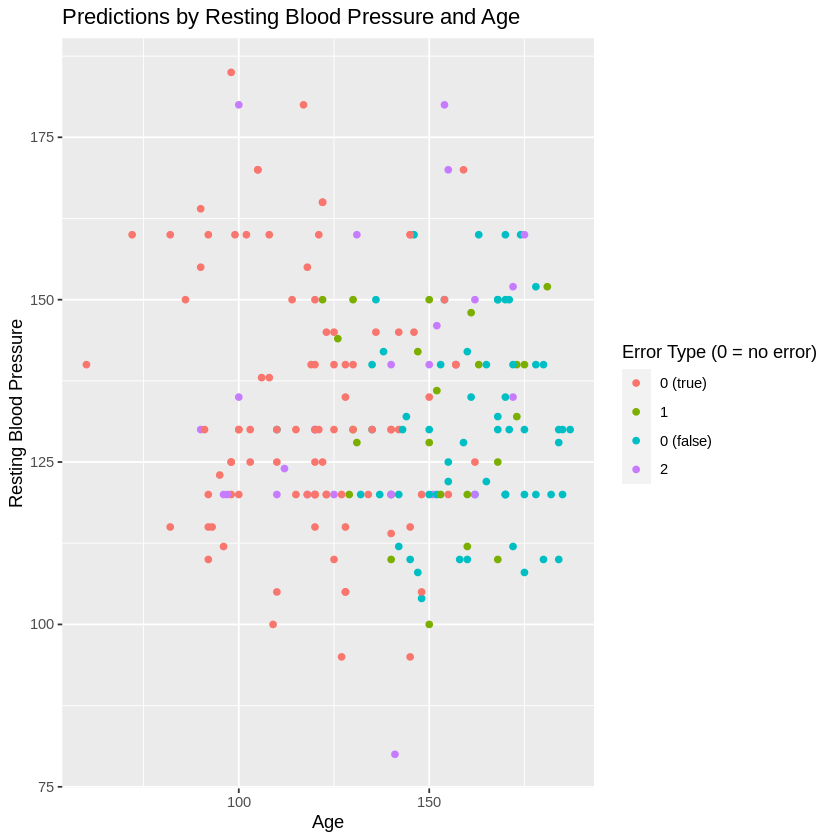

In [46]:
#plot of predictions by error type
errors <- predictions |>
    mutate(error = as_factor(ifelse(num == .pred_class & num == 0, "0 (false)", ifelse(num == .pred_class & num == 1, "0 (true)", ifelse(num == 1, 1, 2)))))
ggplot(errors, aes(x = age, y = trestbps, color = error)) +
  geom_point() +
  labs(x = "Age", y = "Resting Blood Pressure", color = "Error Type (0 = no error)", title = "Predictions by Resting Blood Pressure and Age")